## Predicting Default on Payments of Credit Card Clients

# 3. Model Training & Model Evaluation

Within the ML Analytics Recruitment Challenge, the goal of this notebook is to train machine learning models to predict whether a credit card client will default in the following month and evaluate the performance of these models.

### Imports

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import warnings

from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from typing import Dict, List, Union

seed = 17
np.random.seed(seed)

warnings.filterwarnings("ignore")

shap.initjs()

### Utils

#### Data processor

In [2]:
class DataProcessor:
    """
    Class that aggregates a set of functions for loading, cleaning, feature engineering, encoding,
    and normalize data, among others, with the goal of preparing the data to be feed into a model.
    
    Parameters
    ----------
    mappings : Dict<str, Dict>
        Dictionary that specifies the mapping of categorical features. The keys in the dictionary 
        are the names of the columns that represent the categorical features, and the values are 
        also dictionaries that specify the mapping of the categorical values. 
    
    seed : int, optional
        Integer used to control the random state, default is 17. 
        
    target_col_name : str, optional
        Name of the target variable, default is 'target'.
        
    val_size : float, optional
        Represents the propotion of the train dataset to include in the validation split, by default
        is 0.2.
    """
    def __init__(
        self,
        mappings: Dict,
        seed: int = 17,
        target_col_name: str = "target",
        val_size: float = 0.2
    ):
        self.target_name = target_col_name
        
        self._mappings = mappings
        self._seed = seed
        self._val_size = val_size
        
        
        # Variables to be initialized later:
        self.train_data = None
        self.test_data = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.standard_scaler = None
    
    
    def load_train_data(self, file_directory: str):
        """Loads the train data from a given directory."""
        self.train_data = pd.read_csv(file_directory)
        self._initial_dataset_uniformization(dataset_type="train")
    
    def load_test_data(self, file_directory: str):
        """Loads the test data from a given directory."""
        self.test_data = pd.read_csv(file_directory)
        self._initial_dataset_uniformization(dataset_type="test")
    
    def split_data(self):
        """Splits the train set into train and validation sets, and decomposes all sets into X and y."""
        self.X_train = self.train_data.iloc[:, :-1]
        self.y_train = self.train_data.iloc[:, -1]
        
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train, 
            self.y_train, 
            test_size=self._val_size, 
            shuffle=True,
            random_state=self._seed,
            stratify=self.y_train
        )
        
        self.val_data = pd.concat([self.X_val, self.y_val], axis=1)
        
        self.X_test = self.test_data.iloc[:, :-1]
        self.y_test = self.test_data.iloc[:, -1]
        
    def treat_categorical_variables(self, drop_original_vars: bool = True):
        """Reencodes of 'education' variable and creation of flags for clients who are male, married, or single."""
        self.X_train = self._treat_categorical_variables(self.X_train, drop_original_vars)
        self.X_val = self._treat_categorical_variables(self.X_val, drop_original_vars)
        self.X_test = self._treat_categorical_variables(self.X_test, drop_original_vars)
        
    def feature_engineering(
        self, 
        calculate_bill_to_limit_bal_ratio: bool = False,
        calculate_pay_to_bill_ratio: bool = False,
        calculate_num_negative_bill_statements: bool = False,
        calculate_payment_delays: bool = False,
        calculate_payment_change_rate: bool = False,
        calculate_bill_change_rate: bool = False,
        calculate_total_payment: bool = False,
        list_vars_to_drop: List = None
    ):
        """ """
        self._calculate_bill_to_limit_bal_ratio = calculate_bill_to_limit_bal_ratio
        self._calculate_pay_to_bill_ratio = calculate_pay_to_bill_ratio
        self._calculate_num_negative_bill_statements = calculate_num_negative_bill_statements
        self._calculate_payment_delays = calculate_payment_delays
        self._calculate_payment_change_rate = calculate_payment_change_rate
        self._calculate_bill_change_rate = calculate_bill_change_rate
        self._calculate_total_payment = calculate_total_payment
        self._list_vars_to_drop = list_vars_to_drop
        
        # Perform feature engineering:
        self.X_train = self._feature_engineering(self.X_train)
        self.X_val = self._feature_engineering(self.X_val)
        self.X_test = self._feature_engineering(self.X_test)
        
    def perform_oversampling(
        self, 
        sampling_strategy: Union[str, float] = "minority", 
        k_neighbors: int = 5
    ):
        """Applies the SMOTE algorithm in order to oversample the minority class."""
        self.smote = SMOTE(
            sampling_strategy = sampling_strategy,
            random_state = self._seed,
            k_neighbors = k_neighbors
            
        )
        
        self.X_train, self.y_train = self.smote.fit_resample(self.X_train, self.y_train)
        
        # Rebuild train data:
        self.train_data = pd.concat([self.X_train, self.y_train], axis=1)
    
    def standardize_data(self):
        """Standardize features by removing the mean and scaling to unit variance."""
        col_names = self.X_train.columns
        
        self.transformer = ColumnTransformer(transformers=[
            ("", StandardScaler(), col_names)
        ], remainder="passthrough")
        
        X_train_std = self.transformer.fit_transform(self.X_train)
        self.X_train = pd.DataFrame(X_train_std, columns=col_names)
        
        X_val_std = self.transformer.transform(self.X_val)
        self.X_val = pd.DataFrame(X_val_std, columns=col_names)
        
        X_test_std = self.transformer.transform(self.X_test)
        self.X_test = pd.DataFrame(X_test_std, columns=col_names)
    
    def print_dataset_stats(self, normalize: bool = False):
        """Prints number of samples per set and target classes proportion."""
        print(f"Train dataset: {len(self.X_train)} samples, with the target classes as follow:")
        display(self.train_data.target.value_counts(normalize=normalize))
        
        print(f"Val dataset: {len(self.X_val)} samples, with the target classes as follow:")
        display(self.val_data.target.value_counts(normalize=normalize))
        
        print(f"Test dataset: {len(self.X_test)} samples, with the target classes as follow:")
        display(self.test_data.target.value_counts(normalize=normalize))
        
    def get_datasets(self):
        """Returns the three datasets split into X and y."""
        return self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test
        
    def _map_values(self, col, mapping):
        """Function to encode a column in a dataframe."""
        return col.map(mapping)
    
    def _initial_dataset_uniformization(self, dataset_type: str):
        """Performs initial steps in the dataset such as renaming columns and removing 'id' column."""
        rename_cols_map = {"default.payment.next.month": "target", "PAY_0": "PAY_1"}
        
        if dataset_type == "train":
            self.train_data.rename(columns=rename_cols_map, inplace=True)
            self.train_data.columns = [col.lower() for col in self.train_data.columns]
            self.train_data.drop(columns=["id"], axis=1, inplace=True)
        elif dataset_type == "test":
            self.test_data.rename(columns=rename_cols_map, inplace=True)
            self.test_data.columns = [col.lower() for col in self.test_data.columns]
            self.test_data.drop(columns=["id"], axis=1, inplace=True)
        else:
            raise ValueError(f"dataset_type arg must be 'train' or 'test', got {dataset_type} instead.")
            
    def _treat_categorical_variables(self, data: pd.DataFrame, drop_original_vars: bool = True):
        """Internal function that reencodes of 'education' variable and creation of flags for clients who are male,
        married, or single."""
        assert "education" in self._mappings, "There is no mapping to reencode 'education' variable."
        
        data.education = self._map_values(data.education, self._mappings.get("education"))
        
        data["is_male"] = np.where(data.sex == 1, 1, 0)
        data["is_married"] = np.where(data.marriage == 1, 1, 0)
        data["is_single"] = np.where(data.marriage == 2, 1, 0)
        
        if drop_original_vars:
            data.drop(["sex", "marriage"], axis=1, inplace=True)
                    
        return data
            
    def _feature_engineering(self, data: pd.DataFrame):
        """ """
        def avoid_zero_division(row, pay_amt, bill_amt):
            """"Util function that returns the pay_amtX when bill_amtX is equal to zero."""
            if row[bill_amt] == 0:
                # If pay_amt is positive, it means the client has overpaid:
                return -row[pay_amt]
        
            return 0.0 if row[pay_amt] == 0 else row[pay_amt] / row[bill_amt]
        
        def calculate_change_rate(row, col_amt1, col_amt2):
            """Calculates the change rate (pay_amt or bill_amt) between two consecutive months."""
            if row[col_amt1] == 0:
                return 0.0
            else:
                return (row[col_amt2] - row[col_amt1] / row[col_amt1])

        if self._calculate_bill_to_limit_bal_ratio:
            data["bill_amt1_limit_bal_ratio"] = data.bill_amt1 / data.limit_bal
            data["bill_amt2_limit_bal_ratio"] = data.bill_amt2 / data.limit_bal
            data["bill_amt3_limit_bal_ratio"] = data.bill_amt3 / data.limit_bal
            data["bill_amt4_limit_bal_ratio"] = data.bill_amt4 / data.limit_bal
            data["bill_amt5_limit_bal_ratio"] = data.bill_amt5 / data.limit_bal
            data["bill_amt6_limit_bal_ratio"] = data.bill_amt6 / data.limit_bal
        
        if self._calculate_pay_to_bill_ratio:
            data["pay_amt1_bill_amt1_ratio"] = data.apply(lambda x: avoid_zero_division(x, "pay_amt1", "bill_amt1"), axis=1)
            data["pay_amt2_bill_amt2_ratio"] = data.apply(lambda x: avoid_zero_division(x, "pay_amt2", "bill_amt2"), axis=1)
            data["pay_amt3_bill_amt3_ratio"] = data.apply(lambda x: avoid_zero_division(x, "pay_amt3", "bill_amt3"), axis=1)
            data["pay_amt4_bill_amt4_ratio"] = data.apply(lambda x: avoid_zero_division(x, "pay_amt4", "bill_amt4"), axis=1)
            data["pay_amt5_bill_amt5_ratio"] = data.apply(lambda x: avoid_zero_division(x, "pay_amt5", "bill_amt5"), axis=1)
            data["pay_amt6_bill_amt6_ratio"] = data.apply(lambda x: avoid_zero_division(x, "pay_amt6", "bill_amt6"), axis=1)
        
        if self._calculate_num_negative_bill_statements:
            bill_amt_cols = ["bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6"]
            data["num_overpays"] = (data[bill_amt_cols] < 0).sum(axis=1)
        
        if self._calculate_payment_delays:
            data["payment_delay_amt1"] = (data.bill_amt1 - data.pay_amt1).apply(lambda x: max(0, x))
            data["payment_delay_amt2"] = (data.bill_amt2 - data.pay_amt2).apply(lambda x: max(0, x))
            data["payment_delay_amt3"] = (data.bill_amt3 - data.pay_amt3).apply(lambda x: max(0, x))
            data["payment_delay_amt4"] = (data.bill_amt4 - data.pay_amt4).apply(lambda x: max(0, x))
            data["payment_delay_amt5"] = (data.bill_amt5 - data.pay_amt5).apply(lambda x: max(0, x))
            data["payment_delay_amt6"] = (data.bill_amt6 - data.pay_amt6).apply(lambda x: max(0, x))
        
        if self._calculate_payment_change_rate:
            data["payment_change_rate_amt1_amt2"] = data.apply(lambda x: calculate_change_rate(x, "pay_amt1", "pay_amt2"), axis=1)
            data["payment_change_rate_amt2_amt3"] = data.apply(lambda x: calculate_change_rate(x, "pay_amt2", "pay_amt3"), axis=1)
            data["payment_change_rate_amt3_amt4"] = data.apply(lambda x: calculate_change_rate(x, "pay_amt3", "pay_amt4"), axis=1)
            data["payment_change_rate_amt4_amt5"] = data.apply(lambda x: calculate_change_rate(x, "pay_amt4", "pay_amt5"), axis=1)
            data["payment_change_rate_amt5_amt6"] = data.apply(lambda x: calculate_change_rate(x, "pay_amt5", "pay_amt6"), axis=1)
        
        if self._calculate_bill_change_rate:
            data["bill_change_rate_amt1_amt2"] = data.apply(lambda x: calculate_change_rate(x, "bill_amt1", "bill_amt2"), axis=1)
            data["bill_change_rate_amt2_amt3"] = data.apply(lambda x: calculate_change_rate(x, "bill_amt2", "bill_amt3"), axis=1)
            data["bill_change_rate_amt3_amt4"] = data.apply(lambda x: calculate_change_rate(x, "bill_amt3", "bill_amt4"), axis=1)
            data["bill_change_rate_amt4_amt5"] = data.apply(lambda x: calculate_change_rate(x, "bill_amt4", "bill_amt5"), axis=1)
            data["bill_change_rate_amt5_amt6"] = data.apply(lambda x: calculate_change_rate(x, "bill_amt5", "bill_amt6"), axis=1)
        
        if self._calculate_total_payment:
            pay_amt_cols = ["pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]
            data["total_payment"] = (data[pay_amt_cols]).sum(axis=1)
        
        if self._list_vars_to_drop and len(self._list_vars_to_drop) > 0:
            data.drop(self._list_vars_to_drop, axis=1, inplace=True)
        
        return data
        

#### Model Trainer

In [3]:
class ModelTrainer():
    """ 
    Class that aggregates a set of functions perform feature selection, train and evaluate the models and store the results. 
    Notice that all classifiers used must be compatible with scikit-learn API. This class also requires the passing 
    of three datasets: training, validation and test.
    
    Parameters
    ----------
    
    """
    def __init__(
        self, 
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test, 
        seed
    ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        
        self._seed = seed
        
        self.models = {}
        self.models_results = {}
        self.models_metadata = {}
        
        # Variables to be initialized later:
        self.feature_selector = None
        
    def train_classifier(
        self, 
        classifier: object,
        classifier_name: str,
        perform_feature_selection: bool = False, 
        feature_selection_algorithm: str = None,
        num_features: int = 20,
    ):
        """ """
        if perform_feature_selection:
            self.perform_feature_selection(algorithm=feature_selection_algorithm, num_features=num_features)
            
        classifier.fit(self.X_train, self.y_train)
        
        # Store the trained model:
        self.models[classifier_name] = classifier
        
    def evaluate_classifier(
        self,
        classifier_name: str,
        store_results: bool = True,
        print_classification_report: bool = True,
        display_confusion_matrix: bool = False
    ):
        """ """
        def calculate_metrics(y_true, y_preds, prefix):
            return {
                f"{prefix}_recall_score": round(recall_score(y_true, y_preds), 2),
                f"{prefix}_precision_score": round(precision_score(y_true, y_preds), 2),
                f"{prefix}_f1_score": round(f1_score(y_true, y_preds), 2),
                f"{prefix}_balanced_accuracy_score": round(balanced_accuracy_score(y_true, y_preds), 2)
            }
        
        assert classifier_name in self.models, f"There is no model registered under the name {classifier_name}."
        
        classifier = self.models.get(classifier_name)
        
        train_preds = classifier.predict(self.X_train)
        val_preds = classifier.predict(self.X_val)
        test_preds = classifier.predict(self.X_test)
        
        scores_dict = {}
        
        scores_dict.update(calculate_metrics(self.y_test, test_preds, "test"))
        scores_dict.update(calculate_metrics(self.y_val, val_preds, "val"))
        scores_dict.update(calculate_metrics(self.y_train, train_preds, "train"))
        
        # Store the results in the model trainer:
        if store_results:
            self.models_results[classifier_name] = scores_dict
            
        if print_classification_report:
            print(f"\t#### {classifier_name.upper()} RESULTS ####")
            print("Train scores:")
            print(classification_report(self.y_train.values, train_preds))
            print("Val scores:")
            print(classification_report(self.y_val.values, val_preds))
            print("Test scores:")
            print(classification_report(self.y_test.values, test_preds))
        
        return scores_dict
          
        
    def perform_feature_selection(self, algorithm: str = "mutual_info_classif", num_features: int = 20):
        """Performs feature selection by applying 'SelectKBest' from scikit-learn library. It's prepared to use 1 of 2 
        score functions: mutual_info_classif and f_classif."""
        assert algorithm in ["f_classif", "mutual_info_classif"], f"Expected 'mutual_info_classif' or 'f_classif', got {algorithm} instead."
        
        if algorithm == "mutual_info_classif":
            self.feature_selector = SelectKBest(mutual_info_classif, k=num_features)
        
        else:
            self.feature_selector = SelectKBest(f_classif, k=num_features)
        
        self.feature_selector.fit(self.X_train, self.y_train)
        
        print("Feature selection result:\n", self.feature_selector.get_feature_names_out())
        
        self.X_train = self.X_train[self.feature_selector.get_feature_names_out()]
        self.X_val = self.X_val[self.feature_selector.get_feature_names_out()]
        self.X_test = self.X_test[self.feature_selector.get_feature_names_out()]
        
    def add_classifier_metadata(self, classifier_name: str, metadata: Union[Dict, str]):
        """Allows to store some additional information about the model, namely used params, structure of the pipeline
        used to treat and prepare the data, among others."""
        self.models_metadata[classifier_name] = metadata
        
    def get_datasets(self):
        """Returns the three datasets split into X and y."""
        return self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test
    
    def get_results_dict(self):
        """Returns the dictionary containing the results for the trained models."""
        return self.models_results
    
    def reload_data(self, X_train, y_train, X_val, y_val, X_test, y_test):
        """Reloads the original sets for train, val and test."""
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        

### Modeling - Baseline

To start, we will train five different classifiers and choose the best performing ones to be our baseline models. Then, we will focus on testing various preprocessing pipelines and hyperparameter tuning to improve the results. Regarding metrics, considering not only the importance of detecting clients who are in danger to default but also the target's imbalance, we choose the recall as our primary optimization metric. However, additional metrics will also be calculated (such as precision, f1-score, balanced_accuracy, and others) to help supporting our decision-making process. 

At this initial stage, we will use the original variables and only treat the categorical ones during data preprocessing. We will also perform oversampling (using Smote) on the training data in order to balance the target classes. Feature engineering, feature selection and data standardization won't be performed at this stage.  

In [4]:
train_dir = "../data/train_data.csv"
test_dir = "../data/test_data.csv"

bill_amt_cols = ["bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6"]
pay_amt_cols = ["pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]

mappings = {
    "education": {
        1: 1, #"Graduate School", 
        2: 2, #"University", 
        3: 3, #"High School", 
        4: 4, #"Others",
        5: 4, #"Unknown",
        6: 4, #"Unknown"
        0: 4, #"Unknown"
    }
}

In [5]:
data_processor = DataProcessor(mappings=mappings)

# Load train and test data:
data_processor.load_train_data(train_dir)
data_processor.load_test_data(test_dir)

# Split train into train and val datasets:
data_processor.split_data()

# Deal with categorical variables:
data_processor.treat_categorical_variables(drop_original_vars=True)

# Check datasets composition:
data_processor.print_dataset_stats()

# Apply smote to oversample the minority class:
data_processor.perform_oversampling(sampling_strategy="minority", k_neighbors=5)

Train dataset: 19200 samples, with the target classes as follow:


0    18691
1     5309
Name: target, dtype: int64

Val dataset: 4800 samples, with the target classes as follow:


0    3738
1    1062
Name: target, dtype: int64

Test dataset: 6000 samples, with the target classes as follow:


0    4673
1    1327
Name: target, dtype: int64

The chosen classifiers are: Decision Tree (DT), Random Forest (RF), Extremely Randomized Trees (ERT), Gradient Boosting (GBT) and Support Vector Machine (SVM). These classifiers cover a diverse range of algorithms that have been proven to perform well in various machine learning tasks, and in particular with tabular datasets. Moreover, several papers that used this dataset have implemented one or more of these classifiers to predict the likelihood of a customer entering in default. 

During this stage, we have used scikit-learn's default hyperparameters, except for the random_state, which was set to ensure reproducibility of results.

In [6]:
dtc = DecisionTreeClassifier(random_state=seed)
rfc = RandomForestClassifier(random_state=seed)
etc = ExtraTreesClassifier(random_state=seed)
gbc = GradientBoostingClassifier(random_state=seed)
svc = SVC(random_state=seed)

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = data_processor.get_datasets()

models_trainer = ModelTrainer(
    X_train, y_train, X_val, y_val, X_test, y_test, seed
)

models_trainer.train_classifier(
    classifier=dtc,
    classifier_name="DT",
    perform_feature_selection=False,
    feature_selection_algorithm="f_classif",
    num_features=15
)

models_trainer.evaluate_classifier(
    classifier_name="DT",
    store_results=True,
    print_classification_report=True,
    display_confusion_matrix=False
)

models_trainer.train_classifier(
    classifier=rfc,
    classifier_name="RF",
    perform_feature_selection=False,  # already performed during the previous model
    feature_selection_algorithm="f_classif",
    num_features=15
)

models_trainer.evaluate_classifier(
    classifier_name="RF",
    store_results=True,
    print_classification_report=True,
    display_confusion_matrix=False
)

models_trainer.train_classifier(
    classifier=etc,
    classifier_name="ERT",
    perform_feature_selection=False,  # already performed during the previous models
    feature_selection_algorithm="f_classif",
    num_features=15
)

models_trainer.evaluate_classifier(
    classifier_name="ERT",
    store_results=True,
    print_classification_report=True,
    display_confusion_matrix=False
)

models_trainer.train_classifier(
    classifier=gbc,
    classifier_name="GBT",
    perform_feature_selection=False,  # already performed during the previous models
    feature_selection_algorithm="f_classif",
    num_features=15
)

models_trainer.evaluate_classifier(
    classifier_name="GBT",
    store_results=True,
    print_classification_report=True,
    display_confusion_matrix=False
)

models_trainer.train_classifier(
    classifier=svc,
    classifier_name="SVM",
    perform_feature_selection=False,  # already performed during the previous models
    feature_selection_algorithm="f_classif",
    num_features=15
)

models_trainer.evaluate_classifier(
    classifier_name="SVM",
    store_results=True,
    print_classification_report=True,
    display_confusion_matrix=False
)

results = models_trainer.get_results_dict()

	#### DT RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14953
           1       1.00      1.00      1.00     14953

    accuracy                           1.00     29906
   macro avg       1.00      1.00      1.00     29906
weighted avg       1.00      1.00      1.00     29906

Val scores:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      3738
           1       0.36      0.45      0.40      1062

    accuracy                           0.70      4800
   macro avg       0.60      0.61      0.60      4800
weighted avg       0.73      0.70      0.71      4800

Test scores:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      4673
           1       0.36      0.44      0.40      1327

    accuracy                           0.70      6000
   macro avg       0.60      0.61      0.60      6000
weighted avg 

In [8]:
df_results = pd.DataFrame.from_dict(results, orient="index")
#df_results.reset_index(inplace=True)
#df_results.rename(columns={"index": "classifier_name"}, inplace=True)
df_results.sort_values(by="test_recall_score", ascending=False).T

,SVM,GBT,RF,DT,ERT
test_recall_score,0.72,0.47,0.45,0.44,0.42
test_precision_score,0.30,0.54,0.54,0.36,0.53
test_f1_score,0.43,0.50,0.49,0.40,0.46
test_balanced_accuracy_score,0.62,0.68,0.67,0.61,0.65
val_recall_score,0.69,0.49,0.45,0.45,0.41
val_precision_score,0.29,0.55,0.55,0.36,0.53
val_f1_score,0.41,0.52,0.49,0.40,0.46
val_balanced_accuracy_score,0.61,0.69,0.67,0.61,0.65
train_recall_score,0.71,0.74,1.00,1.00,1.00
train_precision_score,0.61,0.87,1.00,1.00,1.00


All models have signs of overffiting.

DT, RF and ERT are all showing massive signs of overfitting, with 100% of recall in the training dataset but reaching less than 50% of recall on both validation and test sets. There are several potential causes for the overfitting, such as lacking regularization, or model's complexity (too large depth, too many leaves or other inadequate hyperparameter settings), among others. Possible ways of improving these models are through hyperparameter tuning, usage of regularization techniques (like early stopping), perform feature engineering and/or feature selection. 

Although the overfitting in GBT is not so severe when compared to DT, RF and ERT, the overall performance on the test data is still poor. 

SVM was the best performing model at this stage and will be considered our <u>baseline model</u>, with similar results on all three sets. The test recall is 72%. It is also important to notice that the test precision score is only 30%, which contributes for a lower test f1-score of 43%. These results mean that the model is predicting that several clients are defaulting when they're not. Finally, when looking at the precision and f1 scores (train and test), it shows signs of overfitting. 

**We will now proceed with trying to improve the results of SVM.**

The remaining models could certainly benefit from intervention and having their results improved after performing hyperparameter tuning, regularization techniques and revision of the preprocessing pipeline. However, due to time constraints, we are going to proceed with the model that showed the most potential. 

### Modeling - Adding Feature Engineering

In [9]:
svm_data_processor = DataProcessor(mappings=mappings)

# Load train and test data:
svm_data_processor.load_train_data(train_dir)
svm_data_processor.load_test_data(test_dir)

# Split train into train and val datasets:
svm_data_processor.split_data()

# Deal with categorical variables:
svm_data_processor.treat_categorical_variables(drop_original_vars=True)

# Check datasets composition:
svm_data_processor.print_dataset_stats()

# Perform feature engineering:
svm_data_processor.feature_engineering(
    calculate_bill_to_limit_bal_ratio=True,
    calculate_pay_to_bill_ratio=True,
    calculate_num_negative_bill_statements=True,
    calculate_payment_delays=True,
    calculate_payment_change_rate=True,
    calculate_bill_change_rate=True,
    calculate_total_payment=True,
    list_vars_to_drop=bill_amt_cols + pay_amt_cols
)

# Apply smote to oversample the minority class:
svm_data_processor.perform_oversampling(sampling_strategy="minority", k_neighbors=5) # TODO: implement

# Check datasets composition after oversampling:
# data_processor.print_dataset_stats(normalize=True)

# Standardize data:
data_processor.standardize_data()

Train dataset: 19200 samples, with the target classes as follow:


0    18691
1     5309
Name: target, dtype: int64

Val dataset: 4800 samples, with the target classes as follow:


0    3738
1    1062
Name: target, dtype: int64

Test dataset: 6000 samples, with the target classes as follow:


0    4673
1    1327
Name: target, dtype: int64

In [10]:
svc = SVC(random_state=seed)

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = svm_data_processor.get_datasets()

models_trainer = ModelTrainer(X_train, y_train, X_val, y_val, X_test, y_test, seed)

In [12]:
models_trainer.train_classifier(
    classifier=svc,
    classifier_name="SVM_with_feature_engineering",
    perform_feature_selection=False,
    feature_selection_algorithm="f_classif",
    num_features=15
)

models_trainer.evaluate_classifier(
    classifier_name="SVM_with_feature_engineering",
    store_results=True,
    print_classification_report=True,
    display_confusion_matrix=False
)

results = models_trainer.get_results_dict()
df_results_svm = pd.DataFrame.from_dict(results, orient="index")
df_results_svm.sort_values(by="test_recall_score", ascending=False).T

	#### SVM_WITH_FEATURE_ENGINEERING RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.66      0.53      0.59     14953
           1       0.61      0.73      0.66     14953

    accuracy                           0.63     29906
   macro avg       0.64      0.63      0.63     29906
weighted avg       0.64      0.63      0.63     29906

Val scores:
              precision    recall  f1-score   support

           0       0.86      0.52      0.65      3738
           1       0.30      0.71      0.42      1062

    accuracy                           0.56      4800
   macro avg       0.58      0.61      0.53      4800
weighted avg       0.74      0.56      0.60      4800

Test scores:
              precision    recall  f1-score   support

           0       0.88      0.53      0.66      4673
           1       0.31      0.74      0.44      1327

    accuracy                           0.58      6000
   macro avg       0.59      0.64      0.

,SVM_with_feature_engineering
test_recall_score,0.74
test_precision_score,0.31
test_f1_score,0.44
test_balanced_accuracy_score,0.64
val_recall_score,0.71
val_precision_score,0.30
val_f1_score,0.42
val_balanced_accuracy_score,0.61
train_recall_score,0.73
train_precision_score,0.61


There was a slight improvement of the results, although the precision scores remain low when compared to recall scores. There are still no signs of overfitting when looking at recall or balanced accuracy scores, but precision and f1 scores continue to tell a different story. 

Test recall score is now 74%.

### Modeling - Adding Feature Selection

In [25]:
svc = SVC(random_state=seed)

In [26]:
models_trainer_feature_selection = ModelTrainer(X_train, y_train, X_val, y_val, X_test, y_test, seed)

X_train, y_train, X_val, y_val, X_test, y_test = svm_data_processor.get_datasets()

models_trainer_feature_selection.reload_data(X_train, y_train, X_val, y_val, X_test, y_test)

models_trainer_feature_selection.train_classifier(
    classifier=svc,
    classifier_name="SVM_with_f_classif_15",
    perform_feature_selection=True,
    feature_selection_algorithm="f_classif",
    num_features=15
)

models_trainer_feature_selection.evaluate_classifier(
    classifier_name="SVM_with_f_classif_15",
    store_results=True,
    print_classification_report=True,
    display_confusion_matrix=False
)

models_trainer_feature_selection.reload_data(X_train, y_train, X_val, y_val, X_test, y_test)

models_trainer_feature_selection.train_classifier(
    classifier=svc,
    classifier_name="SVM_with_mutual_info_15",
    perform_feature_selection=True,
    feature_selection_algorithm="mutual_info_classif",
    num_features=15
)

models_trainer_feature_selection.evaluate_classifier(
    classifier_name="SVM_with_mutual_info_15",
    store_results=True,
    print_classification_report=True,
    display_confusion_matrix=False
)

results = models_trainer_feature_selection.get_results_dict()
df_results_svm_fs = pd.DataFrame.from_dict(results, orient="index")
df_results_svm_fs.sort_values(by="test_recall_score", ascending=False).T

Feature selection result:
 ['limit_bal' 'pay_1' 'pay_2' 'pay_3' 'pay_4' 'pay_5' 'pay_6' 'is_male'
 'is_married' 'is_single' 'bill_amt3_limit_bal_ratio'
 'bill_amt4_limit_bal_ratio' 'bill_amt5_limit_bal_ratio'
 'bill_amt6_limit_bal_ratio' 'total_payment']
	#### SVM_WITH_F_CLASSIF_15 RESULTS ####
Train scores:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59     14953
           1       0.59      0.61      0.60     14953

    accuracy                           0.60     29906
   macro avg       0.60      0.60      0.60     29906
weighted avg       0.60      0.60      0.60     29906

Val scores:
              precision    recall  f1-score   support

           0       0.84      0.59      0.69      3738
           1       0.30      0.62      0.40      1062

    accuracy                           0.59      4800
   macro avg       0.57      0.60      0.55      4800
weighted avg       0.72      0.59      0.63      4800

Test scores:
           

,SVM_with_mutual_info_15,SVM_with_f_classif_15
test_recall_score,0.72,0.62
test_precision_score,0.30,0.30
test_f1_score,0.42,0.40
test_balanced_accuracy_score,0.62,0.60
val_recall_score,0.70,0.62
val_precision_score,0.29,0.30
val_f1_score,0.41,0.40
val_balanced_accuracy_score,0.61,0.60
train_recall_score,0.72,0.61
train_precision_score,0.60,0.59


Results didn't improve with feature selection. It was tested selecting the k best features, with k = 12, 15 and 20. The best results were obtained with 15 features. However, it didn't overcome the 74% of test recall obtained in the previous set of experiments. 

Unfortunately, it's not guaranteed that SelectKBest will yield the most informative features, considering that uses a single criterion at the time, which may not be optimal. Due to time constraints, no more feature selection techniques were attempted. However, given the time, I would retrain the SVC model using features selected by 'Recursive Feature Elimination' or 'Correlation-based feature selection' methods. Using the feature importance of some tree-based classifiers to rank the features is also an alternative option. 

### Results interpretability

In [27]:
X_train, y_train = models_trainer.X_train, models_trainer.y_train
X_test, y_test = models_trainer.X_test, models_trainer.y_test

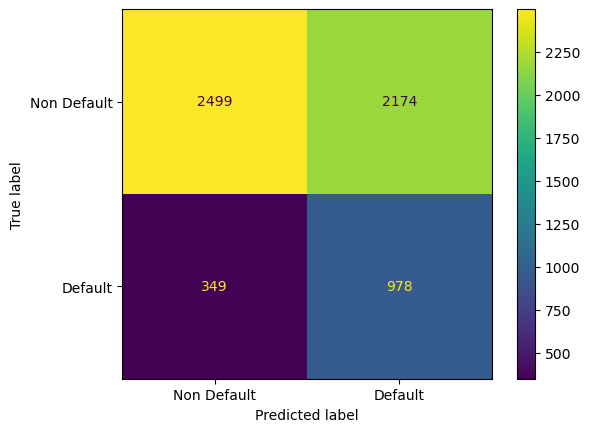

In [36]:
# Confusion matrix
best_model = models_trainer.models.get("SVM_with_feature_engineering")

cm = confusion_matrix(y_test.values, best_model.predict(X_test))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Non Default', 'Default']
)

disp.plot()

plt.show()

In [44]:
tn, fp, fn, tp = cm.ravel()

print(f"True negatives: {tn}")
print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")

print(f"Number of labels predicted as 1 vs 0: {tp + fp} vs. {tn + fn}")

True negatives: 2499
False positives: 2174
False negatives: 349
True positives: 978
Number of labels predicted as 1 vs 0: 3152 vs. 2848


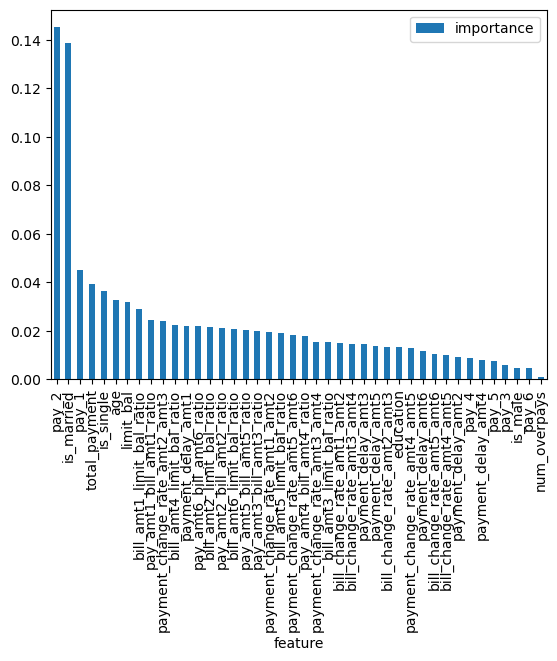

In [49]:
# Feature importance:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)

feat_imp = pd.DataFrame(
    zip(clf.feature_names_in_, clf.feature_importances_),
    columns=["feature", "importance"]
).sort_values(by="importance", ascending=False)

feat_imp.plot.bar(x='feature', y='importance', rot=90)
plt.show()

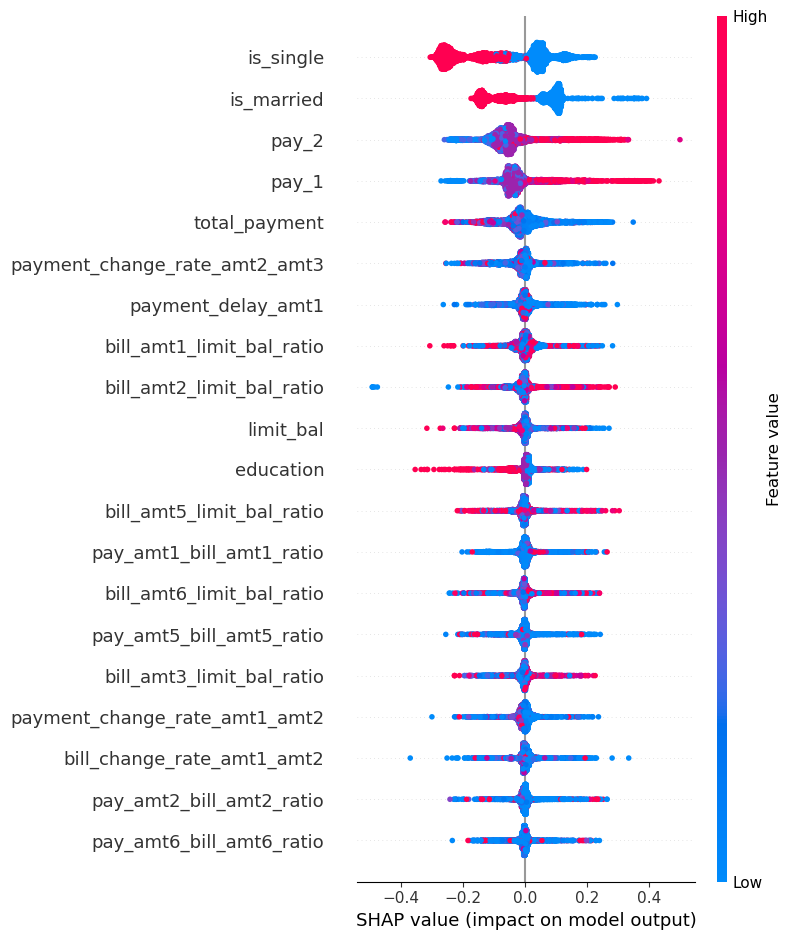

In [50]:
# SHAP values:
# clf = SVC(random_state=seed)
# clf.fit(X_train, y_train)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# explainer = shap.KernelExplainer(clf.predict_proba, X_train)
explainer = shap.TreeExplainer(clf)
shap_values = explainer(test_data)

exp = shap.Explanation(
    shap_values.values[:,:,1], 
    shap_values.base_values[:,1], 
    data=test_data.values, 
    feature_names=test_data.columns
)

shap.summary_plot(
    shap_values=exp,
    features=test_data
)

Unfortunately, due to time constraints, there was no time to adapt the SHAP values to have the interpretation of the SVM model. As an alternative, shap values were calculated for a simple decision tree model. 

### Conclusions and next steps

The results of our analysis showed that the SVM model achieved the best performance with a recall score of 74%. 


The most relevant features to predict the probability of a client defaulting are past payment statuses (in particular the most recent months), paid amount to bill ratios, payment change rates, payment delays, credit limits, the total amount paid by the client during the last 6 months and information regarding client's age and marital status.


Further research is needed to refine the model and improve its performance. 



**Next Steps and future work might include:**
- EDA:
    - Invest more in multivariate analysis
    - Deal with repetitive code
    - Improve feature engineering
    - Treat outliers (IQR)
- Dataset imbalance:
    - Try to get more data from the source
    - Synthetic data
- Feature selection:
    - Explore other methods:
    - Recursive Feature Elimination
    - Correlation-based feature selection 
    - Using the feature importance of some tree-based classifiers to rank the features
    - "Manual selection"
    - Genetic algorithms
- Models:
    - Hyperparameter tuning
    - Regularization techniques (if needed)
    - Deep learning neural networks
- Interpretability:
    - Adapt SHAP values to SVM
- Code:
    - Finish documentation and write a proper readme file, including instructions on how to run the project
    - Add proper logging
    - Refactor DataProcessor and ModelTrainer classes
    - Create a report manager
    - Integration with MLFlow (or similar tool) to facilitate experiment tracking
    - Production code:
        - OOP
        - Unit, integration and acceptance tests
        - Apply lint packages (e.g., autopep8, pylint)
        - Dependencies management (e.g., Poetry)